In [2]:
import numpy as np  
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  
# import plotly.plotly as py # visualization library
from plotly.offline import init_notebook_mode, iplot  
init_notebook_mode(connected=True) 
import plotly.graph_objs as go 
import os
import warnings        
warnings.filterwarnings("ignore") 

In [3]:
#read data
path = "/Users/reign/Downloads/store-sales-time-series-forecasting/"

oil = pd.read_csv(path + 'oil.csv')
trans = pd.read_csv(path + 'transactions.csv')
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

변수설명

oil
- date: 날짜
- dcoilwtico: daily price (변수 설명에 따르면, 이 데이터의 배경인 콜롬비아의 경제는 유가에 크게 의존하고 있다고 한다.)

train
- date: 날짜
- store_nbr: identifies the store at which the products are sold.
- family: 상품군
- sales:: 총판매량 (target)
- onpromption: gives the total number of items in a product family that were being promoted at a store at a given date. 

test
- date: 날짜(train의 마지막 날짜로부터 15일 뒤)
- 나머지, train과 동일

trans
- date: 날짜
- store_nbr: 상점 번호
- transaction: 거래 수

In [4]:
#read data
path = "/Users/reign/Downloads/store-sales-time-series-forecasting/"

oil = pd.read_csv(path + 'oil.csv')
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
trans = pd.read_csv(path + 'transactions.csv')

### EDA

In [5]:
print(train.shape)
print(oil.shape)

(3000888, 6)
(1218, 2)


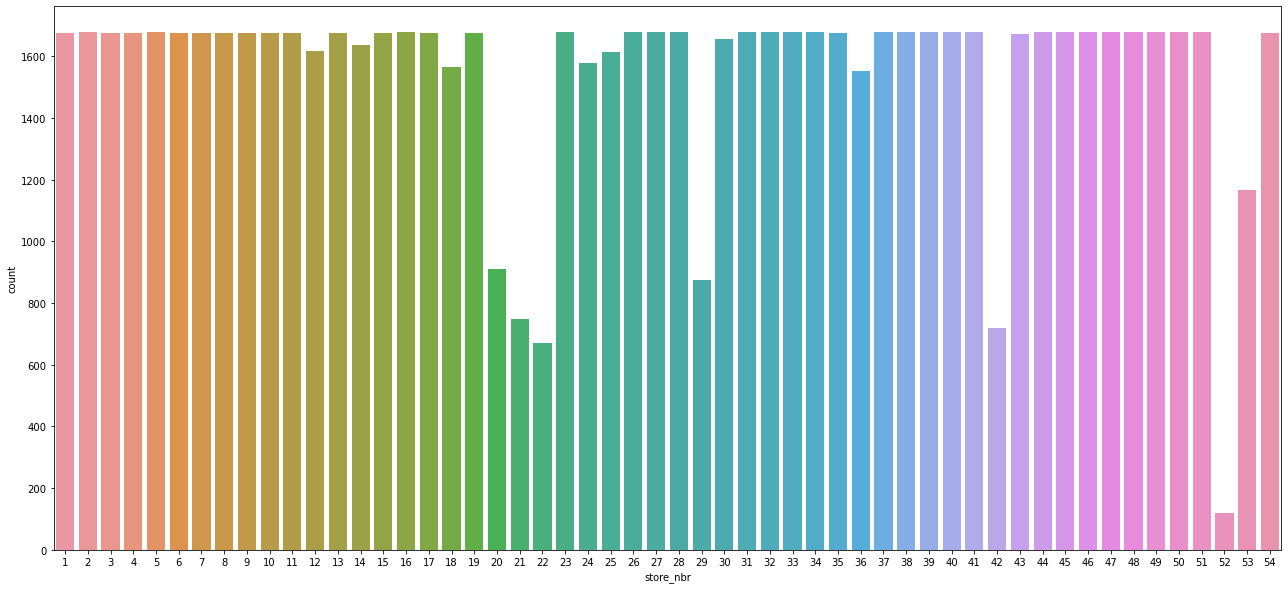

In [6]:
#print(trans['store_nbr'].value_counts())
plt.figure(figsize=(22,10))
sns.countplot(trans['store_nbr'])
plt.show()

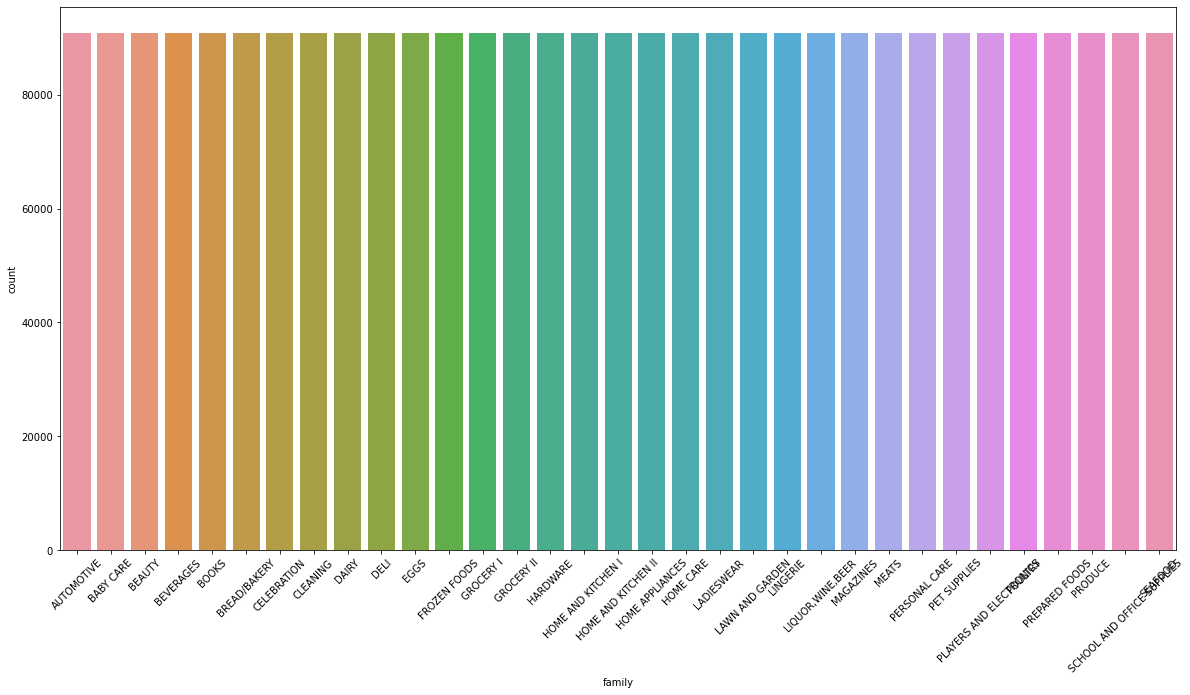

In [7]:
plt.figure(figsize=(20,10))
sns.countplot(train['family'])
plt.xticks(rotation=45)
plt.show()

시계열 시각화(aggregate)

In [8]:
ts1 = train.copy()
ts2 = oil.copy()

In [9]:
#시계열화
ts1['date'] = pd.to_datetime(ts1['date']) #시계열 입히기
ts1['day_of_week'] = ts1['date'].dt.dayofweek
ts1['month'] = ts1['date'].dt.month
ts1['year'] = ts1['date'].dt.year

In [10]:
def tsgroup(df, freq, col):
    df = df.groupby(freq).agg(mean = (col, 'mean')) #or agg('col':'mean')
    df = df.reset_index()
   # print(df)
    plt.figure(figsize=(10,5))
    plt.title(freq)
    plt.plot(df[freq], df['mean'])
    plt.show()

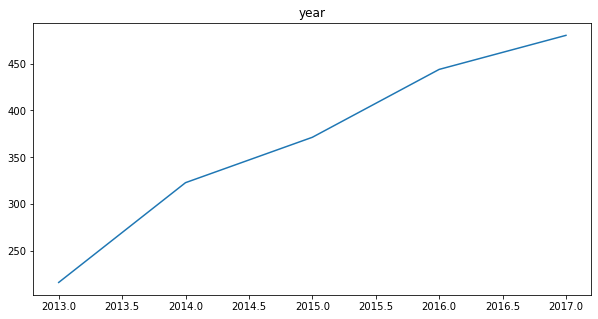

In [11]:
#tsgroup(ts1,'day_of_week','sales')
#tsgroup(ts1,'month','sales')
tsgroup(ts1,'year','sales')

In [12]:
time = ['day_of_week','month','year']

def gbytime(times,df,col):
    #counts=0
    #fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
    #axes = []
    for i in times:
        axes.append(tsgroup(df,i,col))
        axes[counts] = tsgroup(df,i,col)
        #print(counts)
        #counts= counts+1
        
    return axes.show()  

In [13]:
times = ['day_of_week','month','year']
def gbytime(times,df,col):        
        for i in times:
                tsgroup(df,i,col)    

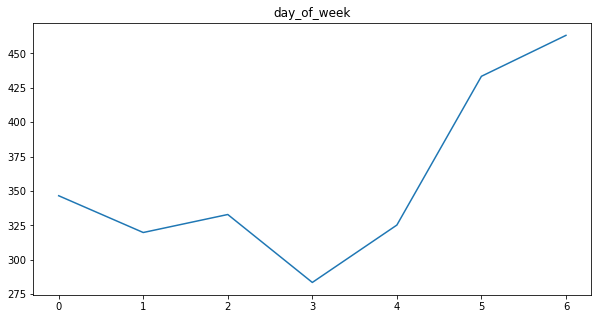

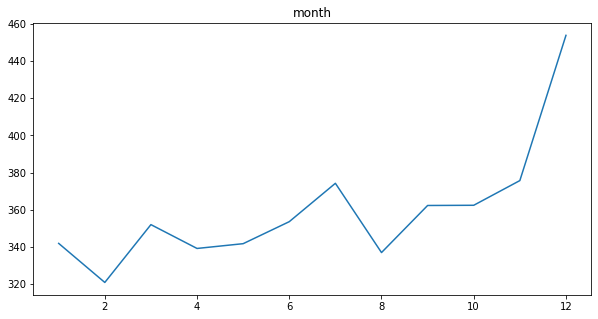

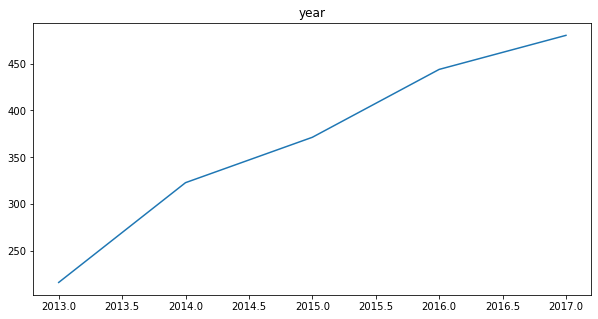

In [14]:
gbytime(time, ts1,'sales')

In [15]:
ts2['date'] = pd.to_datetime(ts2['date'])
ts2['day_of_week'] = ts2['date'].dt.dayofweek
ts2['month'] = ts2['date'].dt.month
ts2['year'] = ts2['date'].dt.year

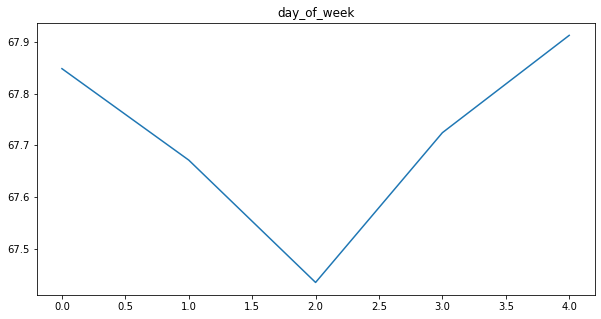

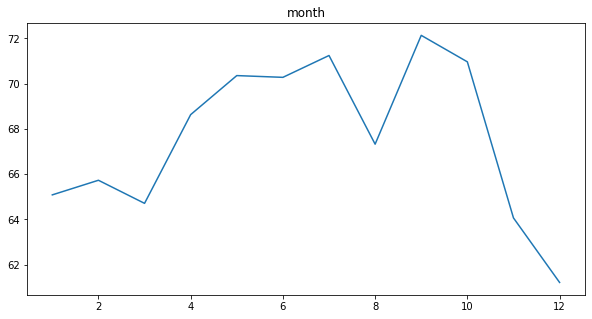

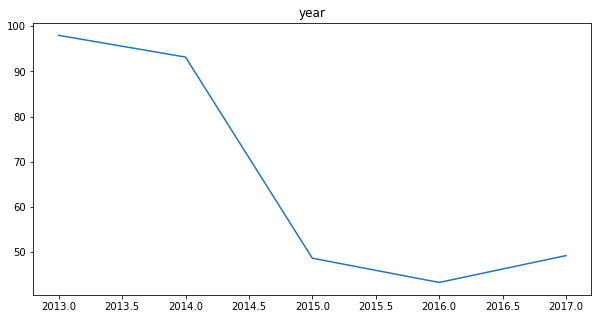

In [16]:
#oil
gbytime(time,ts2,'dcoilwtico')

In [17]:
ts2.groupby('year').mean()

,dcoilwtico,day_of_week,month
year,,,
2013,97.982540,1.996169,6.513410
2014,93.172222,2.000000,6.524904
2015,48.656706,2.003831,6.540230
2016,43.293651,2.007663,6.524904
2017,49.232874,1.988506,4.534483


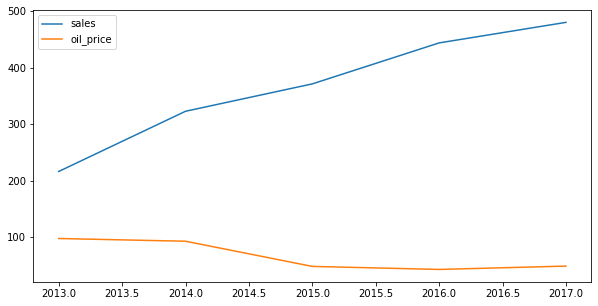

In [18]:
#sales & oil by year
plt.figure(figsize=(10,5))
plt.plot(ts1['year'].unique(),ts1.groupby('year').mean()['sales'],label = "sales")
plt.plot(ts2['year'].unique(),ts2.groupby('year').mean()['dcoilwtico'],label = "oil_price")
plt.legend()
plt.show()

## 전처리

MA(이동평균) for smoothing
- rolling(window지정)
- Grouper(freq지정)

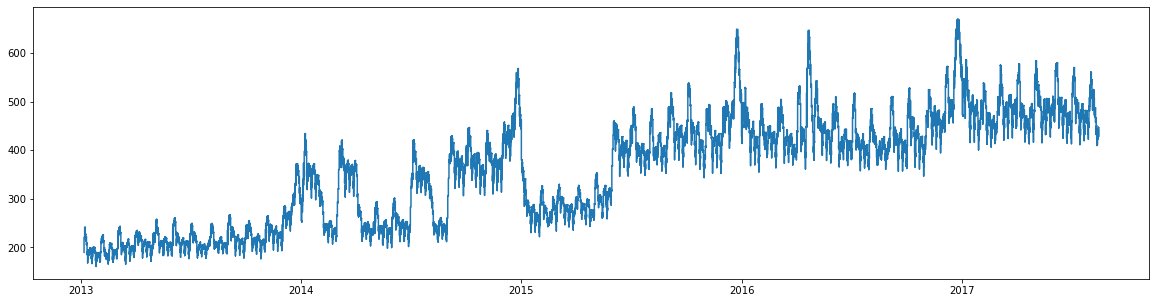

In [19]:
#rolling
window_size = 10000
moving_avg = ts1.rolling(window_size).mean()['sales']
plt.figure(figsize=(20,5))
plt.plot(ts1['date'],moving_avg)
plt.show()

In [20]:
#Grouper #시계열이 중복된 것이 많을 때 유용하다. or 윈도우가 정해져 있을 때
def group(df, key, freq, col):
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index() #date를 인덱스가 아닌 컬럼으로 지정
    return df_grouped

In [56]:
ts1_d = group(ts1, 'date', 'd', 'sales')
ts1_w = group(ts1, 'date', 'w', 'sales')
ts1_m = group(ts1, 'date', 'm', 'sales')
ts1_y = group(ts1, 'date', 'y', 'sales')

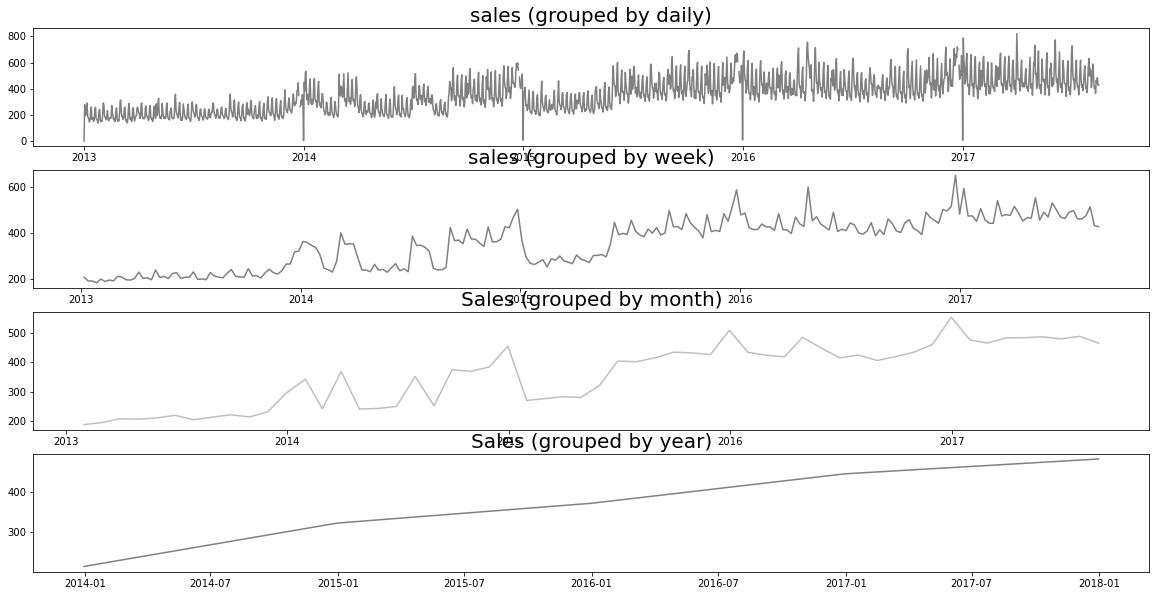

In [57]:
#check the smoothing effect

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20,10))

# sales (daily)

axes[0].plot('date', 'mean', data=ts1_d, color='grey', #marker='o'
)
axes[0].set_title("sales (grouped by daily)", fontsize=20)

# sales (weekly)
axes[1].plot('date', 'mean', data=ts1_w, color='grey', #marker='o'
)
axes[1].set_title("sales (grouped by week)", fontsize=20)

# sales (monthly)
axes[2].plot('date', 'mean', data=ts1_m, color='0.75')
axes[2].set_title("Sales (grouped by month)", fontsize=20)

# sales (yearly)
axes[3].plot('date', 'mean', data=ts1_y, color='0.50')
axes[3].set_title("Sales (grouped by year)", fontsize=20)


plt.show()

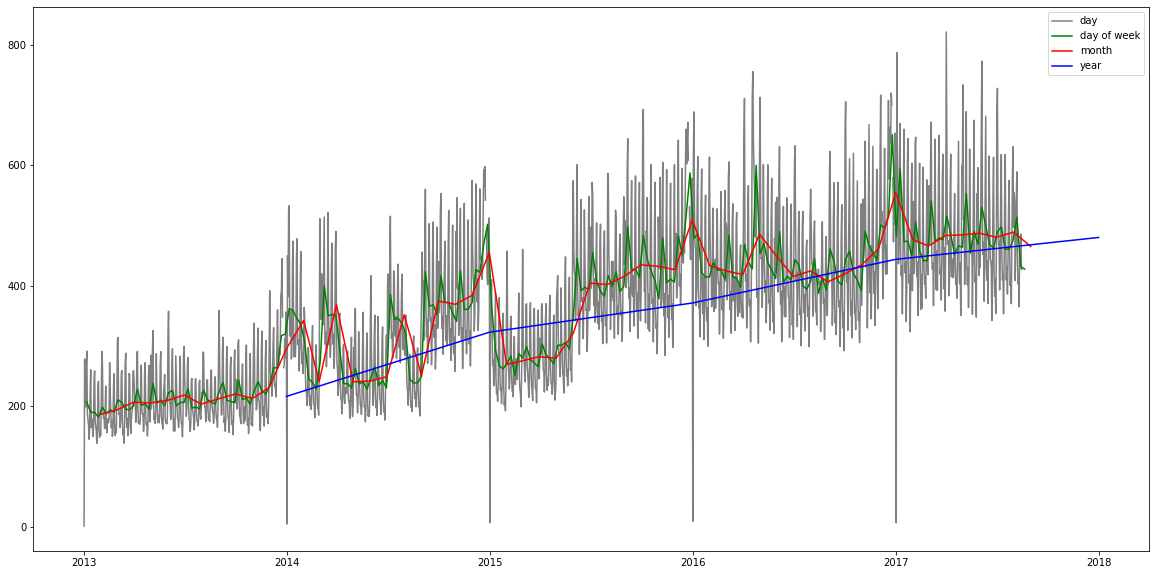

In [66]:
plt.figure(figsize=(20,10))
plt.plot('date', 'mean', data=ts1_d, color='grey', label = "day") #marker='o')
plt.plot('date', 'mean', data=ts1_w, color='g', label = "day of week") #marker='o')
plt.plot('date', 'mean', data=ts1_m, color='r', label = "month")
plt.plot('date', 'mean', data=ts1_y, color='b', label='year')
plt.legend()
#plt.xticks(ts1['date'])
plt.show()

차분(differencing) for 정상시계열

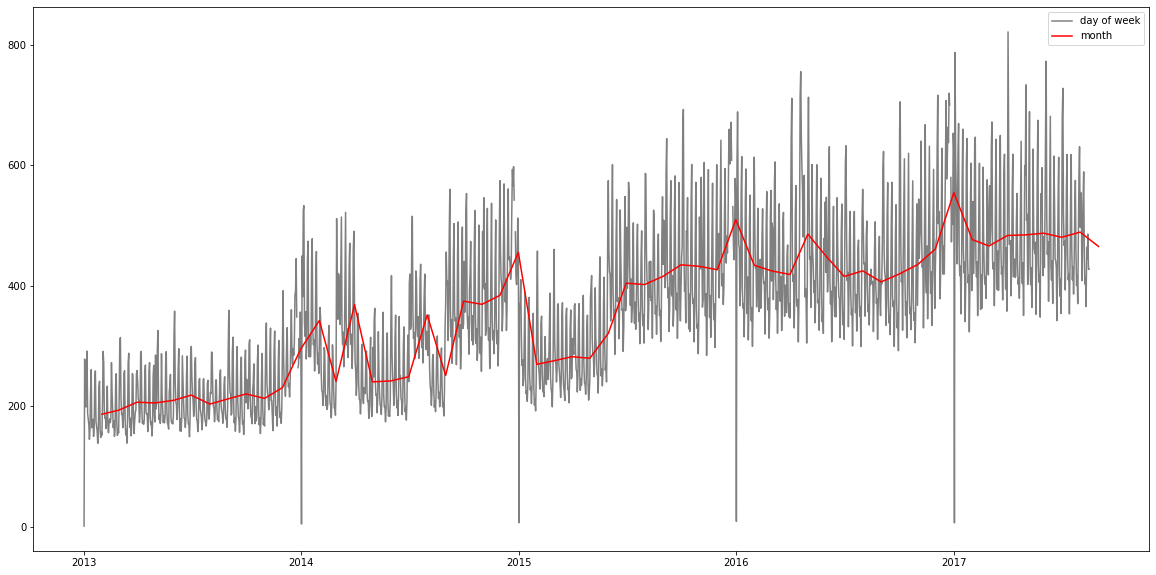

In [64]:
plt.figure(figsize=(20,10))
plt.plot('date', 'mean', data=ts1_d, color='grey', label = "day of week") #marker='o')
plt.plot('date', 'mean', data=ts1_m, color='r', label = "month")

plt.legend()
plt.show()

In [67]:
ts1_m = ts1_m.set_index('date')
ts1_d = ts1_d.set_index('date')
ts_diff = ts1_d - ts1_m
ts_diff = ts_diff.dropna()

<AxesSubplot:xlabel='date', ylabel='mean'>

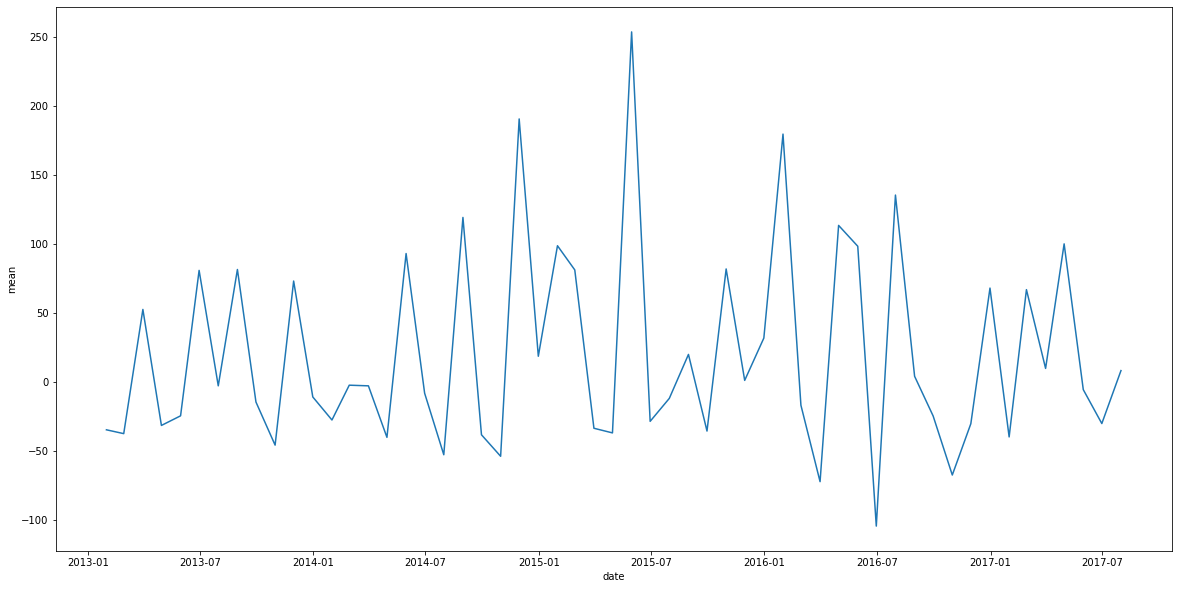

In [72]:
#check the diff effect
plt.figure(figsize=(20,10))
sns.lineplot(ts_diff.index,ts_diff['mean'])

lag-plot(상관관계 확인)

1. 자기상관 확인 (AR모델 고려가능)
2. 이상치 파악
3. 변동 확인

In [106]:
ts_lag = ts1.loc[:, ["date","sales"]]
ts_lag = group(ts_lag, 'date', 'w', 'sales')
ts_lag['lag'] = ts_lag['mean'].shift(1) #lag
ts_lag.dropna()

242

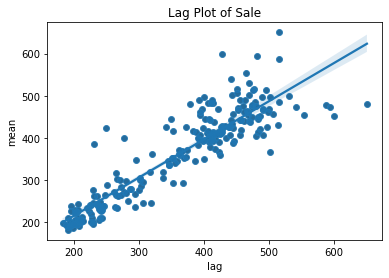

In [132]:
#lag_plot
sns.scatterplot(ts_lag['lag'], ts_lag['mean'], color='0.25')
sns.regplot(ts_lag['lag'], ts_lag['mean'])
plt.title('Lag Plot of Sale')
plt.show()